<a href="https://colab.research.google.com/github/FlyAIBox/AIAgent101/blob/main/06-agent-evaluation/langfuse/01_04_integration_langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 什么是 LangGraph？

[LangGraph](https://langchain-ai.github.io/langgraph/) 是由 LangChain 团队开源的框架，用于基于大语言模型（LLM）构建复杂、有状态的多智能体应用。LangGraph 内置了持久化能力，可保存与恢复状态，从而支持错误恢复与包含“人机交互”（Human-in-the-loop, HITL）的工作流。

## 本实践手册的目标

本手册演示如何借助 [Langfuse](https://langfuse.com/docs)，通过其与 [LangChain 的集成](https://langfuse.com/integrations/frameworks/langchain)，对你的 LangGraph 应用进行调试、分析与迭代优化。

**完成本手册后，你将能够：**

- 自动通过 Langfuse 集成对 LangGraph 应用进行追踪（tracing）
- 监控复杂的多智能体（multi-agent）方案
- 添加评分（例如用户反馈）
- 使用 Langfuse 管理 LangGraph 中使用的提示词（prompt）


## 初始化 Langfuse

在 Langfuse 控制台项目设置页获取你的 [API 密钥](https://langfuse.com/faq/all/where-are-langfuse-api-keys)，并将其加入到运行环境变量中以初始化 Langfuse 客户端。

<!-- CALLOUT_START type: "info" emoji: "⚠️" -->
_**注意：** 本笔记使用 Langfuse Python SDK v3。_
<!-- CALLOUT_END -->

<!-- CALLOUT_START type: "info" emoji: "ℹ️" -->
_**注意：** 需要至少 Python 3.11（参见 [GitHub Issue](https://github.com/langfuse/langfuse/issues/1926)）。_
<!-- CALLOUT_END -->

In [2]:
# %pip install langfuse langchain  langchain_openai langchain_community
%pip install langfuse==3.3.0 langchain==0.3.27 langchain-openai==0.3.31 langchain_community==0.3.27 langgraph==0.6.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.8 MB/s eta 0:00:00
  Attempting uninstall: langchain-openai
    Found existing installation: langchain-openai 0.3.33
    Uninstalling langchain-openai-0.3.33:
      Successfully uninstalled langchain-openai-0.3.33
  Attempting uninstall: langfuse
    Found existing installation: langfuse 3.5.0
    Uninstalling langfuse-3.5.0:
      Successfully uninstalled langfuse-3.5.0
  Attempting uninstall: langchain_community
    Found existing installation: langchain-community 0.3.29
    Uninstalling langchain-community-0.3.29:
      Successfully uninstalled langchain-community-0.3.29


在 Langfuse 控制台的项目设置页获取 API Key，初始化 Langfuse 客户端，并将其设置到环境变量中。

In [4]:
# 🔐 环境变量配置 - 安全存储敏感信息
# 环境变量是存储API密钥等敏感信息的最佳实践
# 避免在代码中硬编码密钥，防止泄露

import os, getpass

def _set_env(var: str):
    """
    安全地设置环境变量
    如果环境变量不存在，会提示用户输入
    使用getpass模块隐藏输入内容，防止密码泄露
    """
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# 🤖 OpenAI API 配置
# OpenAI API密钥：从 https://platform.openai.com/api-keys 获取
# 这是调用GPT模型必需的认证信息
_set_env("OPENAI_API_KEY")

# API代理地址：如果你使用第三方代理服务（如国内代理）
# 示例：https://api.apiyi.com/v1
# 如果直接使用OpenAI官方API，可以留空
_set_env("OPENAI_BASE_URL")

# 🌐 Langfuse 配置
# Langfuse是一个可观测性平台，需要注册账户获取密钥
# 注册地址：https://cloud.langfuse.com

# 公开密钥：用于标识你的项目
_set_env("LANGFUSE_PUBLIC_KEY")

# 秘密密钥：用于认证，请妥善保管
_set_env("LANGFUSE_SECRET_KEY")

# 服务器地址：选择离你最近的区域
# 🇪🇺 欧盟区域(推荐) https://cloud.langfuse.com
# 🇺🇸 美国区域（不推荐） https://us.cloud.langfuse.com
_set_env("LANGFUSE_HOST")

# 💡 初学者提示：
# 1. 环境变量存储在操作系统中，重启后需要重新设置
# 2. 生产环境中建议使用.env文件或云服务配置
# 3. 永远不要在代码中硬编码API密钥！


OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········
LANGFUSE_PUBLIC_KEY: ··········
LANGFUSE_SECRET_KEY: ··········
LANGFUSE_HOST: ··········


在环境变量设置完成后，我们即可初始化 Langfuse 客户端。`get_client()` 会使用环境变量中提供的凭据来初始化 Langfuse 客户端。

In [5]:
from langfuse import get_client

# 🚀 初始化 Langfuse 客户端
# get_client() 会自动读取环境变量中的配置信息
langfuse = get_client()

# 🔍 验证客户端连接状态
# 这个步骤非常重要，确保后续的追踪功能能够正常工作
if langfuse.auth_check():
    print("✅ Langfuse 客户端已通过身份验证，准备就绪！")
    print("🔧 现在可以开始使用追踪功能了")
else:
    print("❌ 身份验证失败！")
    print("🔍 请检查以下配置项：")
    print("   - LANGFUSE_PUBLIC_KEY 是否正确")
    print("   - LANGFUSE_SECRET_KEY 是否正确")
    print("   - LANGFUSE_HOST 是否可访问")
    print("   - 网络连接是否正常")

✅ Langfuse 客户端已通过身份验证，准备就绪！
🔧 现在可以开始使用追踪功能了


## 示例 1：使用 LangGraph 构建简单聊天应用

**本节将完成：**

- 在 LangGraph 中构建一个可回答常见问题的客服聊天机器人
- 使用 Langfuse 对机器人的输入与输出进行追踪（tracing）

我们先从一个基础机器人入手，随后在下一节扩展为更高级的多智能体（multi-agent）设置，并在过程中介绍关键的 LangGraph 概念。

### 创建智能体（Agent）

首先创建一个 `StateGraph`。`StateGraph` 定义了聊天机器人的状态机结构。我们会添加节点来表示 LLM 以及机器人可调用的函数，并通过边（edge）定义机器人在这些函数之间的状态流转。

In [6]:
# 🔧 导入 LangGraph 构建智能体所需的核心模块
from typing import Annotated
from langchain_openai import ChatOpenAI  # OpenAI 聊天模型
from langchain_core.messages import HumanMessage  # 人类消息类型
from typing_extensions import TypedDict  # 类型化字典
from langgraph.graph import StateGraph  # LangGraph 状态图
from langgraph.graph.message import add_messages  # 消息添加函数

# 📋 定义智能体的状态结构
# State 是一个类型化字典，定义了智能体在执行过程中需要维护的状态信息
class State(TypedDict):
    # 💬 消息列表：存储对话历史
    # Annotated[list, add_messages] 的含义：
    # - list: 消息的数据类型是列表
    # - add_messages: 指定状态更新策略，新消息会追加到列表末尾而不是覆盖整个列表
    # 这种设计确保了对话历史的完整保存
    messages: Annotated[list, add_messages]

# 🏗️ 创建状态图构建器
# StateGraph 是 LangGraph 的核心组件，用于定义智能体的工作流程
graph_builder = StateGraph(State)

# 🤖 初始化语言模型
# 选择 GPT-4o 模型，temperature=0.2 确保输出相对稳定但仍有一定创造性
llm = ChatOpenAI(model="gpt-4o", temperature=0.2)

# 🔄 定义聊天机器人节点函数
# 这是 LangGraph 节点函数的基本模式：接收当前状态，返回更新后的状态
def chatbot(state: State):
    """
    聊天机器人节点的核心逻辑

    参数:
        state (State): 当前的智能体状态，包含消息历史

    返回:
        dict: 包含新生成消息的状态更新

    工作流程:
    1. 获取当前的消息历史
    2. 将消息历史发送给语言模型
    3. 接收模型生成的回复
    4. 将回复包装成状态更新返回
    """
    # 调用语言模型处理当前对话历史，生成回复
    response = llm.invoke(state["messages"])

    # 返回状态更新：将模型的回复添加到消息列表中
    return {"messages": [response]}

# 🔗 向图中添加"chatbot"节点
# 节点代表工作单元，通常是普通的 Python 函数
# 每个节点负责特定的处理逻辑，如调用 LLM、处理工具、数据转换等
graph_builder.add_node("chatbot", chatbot)

# 🚀 设置图的入口点
# 告诉图每次运行时从哪个节点开始执行
# 在这个简单示例中，我们直接从 chatbot 节点开始
graph_builder.set_entry_point("chatbot")

# 🏁 设置图的结束点
# 指示图"当这个节点运行完成后，可以退出执行"
# 对于简单的单轮对话，chatbot 节点执行完就可以结束
graph_builder.set_finish_point("chatbot")

# ⚙️ 编译图形为可执行对象
# compile() 方法将图构建器转换为 CompiledGraph
# CompiledGraph 是可以实际运行的图形对象，支持 invoke、stream 等方法
graph = graph_builder.compile()

# 💡 理解 LangGraph 的核心概念：
# 🏗️ StateGraph: 定义智能体的状态和工作流程
# 🔄 Node: 执行具体任务的函数，如调用 LLM、使用工具等
# 🔗 Edge: 连接节点，定义执行顺序和条件跳转
# 📊 State: 智能体运行过程中维护的数据结构
# ⚙️ CompiledGraph: 编译后的可执行图形对象

### 在调用时添加 Langfuse 回调

现在，为了追踪应用执行过程，我们将添加 [面向 LangChain 的 Langfuse 回调处理器](https://langfuse.com/integrations/frameworks/langchain)：`config={"callbacks": [langfuse_handler]}`

In [8]:
from langfuse.langchain import CallbackHandler

# 🛎️ 初始化 Langfuse 回调处理器
# 该处理器会自动捕获 LangChain/LangGraph 的执行细节，用于：
# - 🕒 记录每个节点的耗时与延迟
# - 📝 保存输入、输出及中间状态
# - 💰 统计 token 消耗和 API 调用成本
# - 🐞 收集异常信息，便于排错
# - 📈 在 Langfuse 中生成可视化调用链
langfuse_handler = CallbackHandler()

# 🚀 运行智能体并启用 Langfuse 追踪
print("🤖 智能体开始运行，正在处理问题……")
print("❓ 用户提问：什么是 Langfuse？")
print("📋 执行过程:")

# 使用 stream 方法可以实时查看智能体的执行步骤
for step_result in graph.stream(
    {"messages": [HumanMessage(content="什么是 Langfuse？请详细介绍其主要功能和典型应用场景。")]},
    config={"callbacks": [langfuse_handler]}
):
    print(f"📤 节点执行结果：{step_result}")

print(
"✅ 智能体执行完成！")
print("🔍 请前往 Langfuse 控制台查看完整的追踪记录。")

🤖 智能体开始运行，正在处理问题……
❓ 用户提问：什么是 Langfuse？
📋 执行过程:
📤 节点执行结果：{'chatbot': {'messages': [AIMessage(content='Langfuse 是一个专门用于监控和调试生成式 AI 应用程序的工具。它提供了一系列功能，帮助开发者和企业更好地理解和优化他们的 AI 模型和应用程序。以下是 Langfuse 的主要功能和典型应用场景：\n\n### 主要功能\n\n1. **请求跟踪和监控**：\n   - Langfuse 可以实时跟踪和记录生成式 AI 应用程序的请求和响应。这包括输入数据、输出结果以及相关的元数据。\n   - 提供详细的日志记录功能，帮助开发者识别和解决潜在的问题。\n\n2. **性能分析**：\n   - 提供性能指标和分析工具，帮助用户了解模型的响应时间、准确性和资源使用情况。\n   - 可以生成报告，帮助团队优化模型性能。\n\n3. **错误检测和调试**：\n   - 自动检测异常和错误，提供详细的错误报告和调试信息。\n   - 支持设置警报和通知，以便及时处理问题。\n\n4. **用户行为分析**：\n   - 分析用户与生成式 AI 应用的交互行为，帮助优化用户体验。\n   - 提供用户反馈收集功能，以便持续改进应用程序。\n\n5. **集成和扩展性**：\n   - 支持与各种 AI 平台和工具集成，如 OpenAI、Hugging Face 等。\n   - 提供 API 和 SDK，方便开发者将 Langfuse 集成到现有系统中。\n\n### 典型应用场景\n\n1. **生成式对话系统**：\n   - 用于监控和优化聊天机器人或虚拟助手的性能和用户交互。\n   - 帮助识别对话中的常见问题和用户反馈，以改进对话质量。\n\n2. **内容生成平台**：\n   - 在自动化内容生成应用中使用 Langfuse 来确保生成内容的质量和一致性。\n   - 分析生成内容的风格和主题，以满足用户需求。\n\n3. **推荐系统**：\n   - 监控推荐算法的效果和用户满意度。\n   - 通过行为分析优化推荐策略，提高用户参与度。\n\n4. **AI 驱动的产品开发**：\n   - 在开发过程中使用 Langfuse 进行持续监

### 在 Langfuse 中查看追踪结果

示例追踪：https://cloud.langfuse.com/project/cmequpe0j00euad07w6wrvkzg/traces?peek=cbc8503a9a111fc5eadb5e914be3fa7a&timestamp=2025-09-22T03%3A48%3A16.647Z&observation=47245ec86916a5d1


![在 Langfuse 中查看聊天应用的追踪](https://cdn.jsdelivr.net/gh/Fly0905/note-picture@main/imag/202509221150147.png)

### 可视化聊天应用

你可以使用 `get_graph` 方法配合相应的 “draw” 方法对图进行可视化。

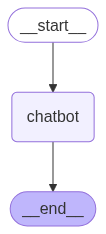

In [9]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

```mermaid
graph TD;
	__start__([__start__]):::first
	chatbot(chatbot)
	__end__([__end__]):::last
	__start__ --> chatbot;
	chatbot --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc
```

### 在 LangGraph Server 中使用 Langfuse

#### 🖥️ LangGraph Server 简介

[LangGraph Server](https://langchain-ai.github.io/langgraph/concepts/langgraph_server/) 是 LangGraph 提供的服务器部署方案，用于将本地构建的图工作流发布为可扩展的在线服务，具备以下能力：

- 🌐 **HTTP API 接口**：将 LangGraph 智能体封装为 REST API，便于与业务系统集成
- 🚀 **生产级运行**：支持高并发、负载均衡与容器化交付
- 🔧 **运维友好**：自动处理请求路由、状态恢复与错误重试
- 📊 **监控集成**：兼容主流监控与追踪体系，便于观测运行状况
- 🔒 **安全管控**：内置身份认证与授权机制，满足企业安全需求

#### 💡 为什么要在 Server 环境接入 Langfuse？

- 🏭 **生产可观测性**：实时查看线上请求的调用链与状态
- 🐛 **远程调试**：无需复现场景即可还原问题细节
- 📈 **性能洞察**：量化每个节点的耗时与成本
- 💰 **费用治理**：准确统计第三方 API 的调用量与费用
- 👥 **团队协作**：共享追踪记录，支持跨职能协同排查


#### 🔧 配置方法说明

使用 LangGraph Server 时，智能体图的调用由服务器自动处理，用户无法在每次请求时手动指定回调处理器。

**关键差异：**
- 🏠 **本地开发**：可以在每次调用时添加 `config={"callbacks": [langfuse_handler]}`
- 🖥️ **服务器部署**：需要在图编译时预先配置回调处理器

**解决方案：**
在声明和编译图时就添加 Langfuse 回调，这样服务器上的所有请求都会自动启用追踪功能。

In [10]:
# 🔧 导入服务器部署所需的模块
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langfuse.langchain import CallbackHandler

# 📋 定义与前文一致的智能体状态结构
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 🏗️ 构建图形结构
graph_builder = StateGraph(State)

# 🤖 初始化语言模型
llm = ChatOpenAI(model="gpt-4o", temperature=0.2)

# 🔄 定义聊天机器人节点
def chatbot(state: State):
    """处理用户消息并生成回复。"""
    return {"messages": [llm.invoke(state["messages"])]}

# 🔗 组装图形结构
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

# 🔄 初始化 Langfuse 回调处理器（服务器模式）
# 在服务器环境中，此处理器会自动追踪所有请求的执行情况
langfuse_handler = CallbackHandler()

# ⚙️ 编译图形并预配置回调处理器
# 🎯 核心方法：with_config()
# - compile()：编译图形，生成可执行的 CompiledGraph
# - with_config()：为编译后的图形设置默认配置（如回调处理器）
#
# 💡 工作流程：
# 1. 编译图形得到 CompiledGraph 对象
# 2. 调用 with_config() 注入 Langfuse 回调
# 3. 返回一个已内置追踪能力的新图对象
#
# 🚀 优势：
# - 无需在每次请求时手动添加回调配置
# - 所有 API 请求都会自动写入 Langfuse 追踪
# - 简化生产环境的部署与运维
graph = graph_builder.compile().with_config({"callbacks": [langfuse_handler]})

# 💡 部署提示：
# 在 LangGraph Server 中直接引用此 graph，即可立即获得完整的追踪数据


## 示例 2：基于 LangGraph 的多智能体应用

**本节将完成：**

- 构建 2 个执行智能体：一个研究智能体使用 LangChain 的 WikipediaAPIWrapper 搜索维基百科，另一个使用自定义工具获取当前时间
- 构建一个智能体监督者（supervisor），用于将用户问题分配给上述智能体
- 添加 Langfuse 回调以追踪监督者与执行智能体的步骤

In [11]:
%pip install langfuse langgraph langchain langchain_openai langchain_experimental pandas wikipedia

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 5.1 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=6ec572a7ab1052346e4522f42f558d8c612784d5cc8796ae199d851a5ab8be2a
  Stored in directory: /root/.cache/pip/wheels/63/47/7c/a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
Successfully built wikipedia


### 创建工具

在本示例中，我们将构建一个用于维基百科检索的智能体，以及一个用于告知当前时间的智能体。先定义它们将使用的工具：

In [12]:
# 🔧 导入多智能体系统所需的工具和模块
from typing import Annotated
from langchain_community.tools import WikipediaQueryRun  # 维基百科查询工具
from langchain_community.utilities import WikipediaAPIWrapper  # 维基百科 API 封装
from datetime import datetime  # 时间处理模块
from langchain.tools import Tool  # 通用工具定义类

# 🔍 定义维基百科搜索工具
# 功能：根据查询词在维基百科中搜索相关信息
# 适用场景：回答百科知识、历史事件、人物传记等问题
wikipedia_tool = WikipediaQueryRun(
    api_wrapper=WikipediaAPIWrapper(
        top_k_results=2,  # 返回最相关的2个搜索结果
        doc_content_chars_max=1000  # 限制每个结果的字符数，避免信息过载
    )
)

# ⏰ 定义当前时间查询工具
# 功能：返回当前的日期和时间信息
# 适用场景：回答"现在几点"、"今天是什么日期"等时间相关问题
datetime_tool = Tool(
    name="Datetime",  # 工具名称，智能体会通过这个名称调用工具
    func=lambda x: datetime.now().isoformat(),  # 工具函数：返回 ISO 格式的当前时间
    description="返回当前的日期和时间信息（ISO 格式）",  # 工具描述，帮助智能体理解何时使用此工具
)

# 💡 工具设计原则：
# 1. 🎯 单一职责：每个工具只负责一个特定功能
# 2. 📝 清晰描述：description 要准确描述工具的功能和使用场景
# 3. 🔒 错误处理：生产环境中应该添加异常处理逻辑
# 4. ⚡ 性能考虑：限制返回数据的大小，避免影响整体性能

### 🛠️ 辅助工具函数

#### 📝 功能说明
下面定义的辅助函数用于简化添加新的智能体工作节点。这些函数封装了创建智能体和节点的通用逻辑，提高代码的可重用性和可维护性。

#### 🎯 设计目标
- **减少重复代码**：避免为每个智能体重复编写相同的初始化逻辑
- **标准化接口**：确保所有智能体节点具有一致的输入输出格式
- **简化扩展**：新增智能体时只需关注业务逻辑，无需处理框架细节

In [13]:
# 🔧 导入智能体构建所需的核心组件
from langchain.agents import AgentExecutor, create_openai_tools_agent  # 智能体执行器和创建函数
from langchain_core.messages import BaseMessage, HumanMessage  # 消息基类和人类消息
from langchain_openai import ChatOpenAI  # OpenAI 聊天模型

def create_agent(llm: ChatOpenAI, system_prompt: str, tools: list):
    """
    🏭 智能体工厂函数：创建具有特定能力的工作智能体

    参数:
        llm (ChatOpenAI): 语言模型实例
        system_prompt (str): 系统提示词，定义智能体的角色和行为规范
        tools (list): 智能体可使用的工具列表

    返回:
        AgentExecutor: 配置完成的智能体执行器

    🔄 工作流程:
    1. 构建提示模板（包含系统角色、对话历史、工具使用记录）
    2. 创建支持工具调用的 OpenAI 智能体
    3. 包装为执行器，处理工具调用和状态管理
    """
    # 📋 构建智能体的提示模板
    # 包含三个关键部分：系统角色、对话历史、工具使用记录
    prompt = ChatPromptTemplate.from_messages([
        # 🎭 系统消息：定义智能体的角色、能力和行为规范
        ("system", system_prompt),
        # 💬 消息历史：保存与用户和其他智能体的对话记录
        MessagesPlaceholder(variable_name="messages"),
        # 🔧 工具记录：记录智能体使用工具的过程和结果
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])

    # 🤖 创建支持 OpenAI 工具调用的智能体
    # 这个智能体能够理解何时需要使用工具，以及如何解释工具的返回结果
    agent = create_openai_tools_agent(llm, tools, prompt)

    # 🎮 创建智能体执行器
    # 执行器负责：工具调用、错误处理、状态管理、结果整合
    executor = AgentExecutor(
        agent=agent,
        tools=tools,
        verbose=True,  # 显示详细的执行过程，便于调试
        handle_parsing_errors=True  # 自动处理解析错误，提高稳定性
    )

    return executor

def agent_node(state, agent, name):
    """
    🔄 智能体节点适配器：将智能体包装为 LangGraph 节点

    参数:
        state: 当前的图状态，包含消息历史和其他上下文信息
        agent: 智能体执行器实例
        name: 智能体的名称，用于在多智能体系统中标识消息来源

    返回:
        dict: 包含智能体响应的状态更新

    🔄 适配过程:
    1. 调用智能体处理当前状态
    2. 提取智能体的输出结果
    3. 包装为带有发送者身份的消息
    4. 返回状态更新
    """
    # 📤 调用智能体处理当前状态
    # agent.invoke() 会处理对话历史，决定是否使用工具，并生成最终回复
    result = agent.invoke(state)

    # 🏷️ 将智能体的输出包装为带有身份标识的消息
    # name 参数让系统知道这条消息来自哪个智能体
    return {
        "messages": [HumanMessage(
            content=result["output"],  # 智能体生成的文本内容
            name=name  # 消息发送者的身份标识
        )]
    }

### 🎯 创建智能体监督者

#### 📋 监督者的核心职责
智能体监督者是多智能体系统的"大脑"，负责：

- 🧠 **任务理解**：分析用户请求，理解任务的性质和需求
- 🎯 **智能体选择**：根据任务特点选择最适合的工作智能体
- 🔄 **流程控制**：决定何时切换智能体，何时结束处理流程
- 📊 **结果整合**：汇总各个智能体的工作成果

#### 🔧 技术实现方式
监督者使用 **函数调用（Function Calling）** 技术来实现决策：

- 📞 **函数调用**：通过结构化的函数调用来表达决策结果
- 🎛️ **选择机制**：在可用的工作节点中选择下一个执行者
- 🏁 **终止条件**：判断何时任务已完成，可以结束处理流程

#### 💡 设计优势
- **精确控制**：避免随机或不确定的路由决策
- **可解释性**：每个决策都有明确的逻辑依据
- **可扩展性**：容易添加新的工作智能体和决策规则

In [14]:
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["Researcher", "CurrentTime"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# 🧭 监督者节点由 LLM 扮演，负责选择下一位执行的智能体并判断流程是否结束
options = ["FINISH"] + members

# 🔁 使用 OpenAI Function Calling，可让结构化输出和解析更加稳定
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}

# 📜 构建监督者提示模板
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4o")

# 🔗 构建监督者智能体的执行链
supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)


/tmp/ipython-input-1811809048.py:52: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


### 构建图形结构

现在可以开始搭建整张图。下面使用刚刚定义的函数指定状态和各个工作节点，并连接图中的所有边。


In [15]:
import functools
import operator
from typing import Sequence, TypedDict
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START

# 🗂️ 智能体状态会作为每个节点的输入数据
class AgentState(TypedDict):
    # Annotated 告诉图：新的消息会追加到现有消息列表中
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # next 字段指示下一步要跳转到哪个节点
    next: str

# 🧑‍💻 使用辅助函数创建研究智能体
research_agent = create_agent(llm, "You are a web researcher.", [wikipedia_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# 🕰️ 创建报时智能体
currenttime_agent = create_agent(llm, "You are a time keeping assistant who tells the current time.", [datetime_tool])
currenttime_node = functools.partial(agent_node, agent=currenttime_agent, name="CurrentTime")

workflow = StateGraph(AgentState)

# 📦 注册节点：节点代表具体的工作单元，通常是 Python 函数
workflow.add_node("Researcher", research_node)
workflow.add_node("CurrentTime", currenttime_node)
workflow.add_node("supervisor", supervisor_chain)

# 🔂 强制所有工作节点在完成后回到监督者
for member in members:
    workflow.add_edge(member, "supervisor")

# 🔀 条件边根据当前状态决定后续路由
# 该函数读取状态并返回要执行的下一个节点名称
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# 🚪 设置入口节点，确定图在运行时从哪里开始
workflow.add_edge(START, "supervisor")

# ⚙️ 编译图形，得到可调用的 CompiledGraph
graph_2 = workflow.compile()


### 在调用中挂载 Langfuse 回调

在执行 `graph_2.stream` 时增加 [Langfuse 回调处理器](https://langfuse.com/integrations/frameworks/langchain)：`config={"callbacks": [langfuse_handler]}`。


In [16]:
from langfuse.langchain import CallbackHandler

# 📡 初始化 Langfuse 回调处理器，用于记录 LangChain 的执行轨迹
langfuse_handler = CallbackHandler()

# 🔗 将回调处理器挂载到图的 stream 调用中；可选的 run_name 会作为追踪名称展示
for s in graph_2.stream({"messages": [HumanMessage(content="光合作用是如何进行的？")]},
                       config={"callbacks": [langfuse_handler]}):
    print(s)
    print("----")


{'supervisor': {'next': 'Researcher'}}
----


> Entering new AgentExecutor chain...


ValidationError: 1 validation error for ToolAgentAction
tool_call_id
  Input should be a valid string [type=string_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type

In [ ]:
# 🔗 同样地，为其他查询挂载 Langfuse 回调
for s in graph_2.stream({"messages": [HumanMessage(content="现在的准确时间是多少？")]},
                       config={"callbacks": [langfuse_handler]}):
    print(s)
    print("----")


### 在 Langfuse 中查看多智能体追踪

以下链接展示了本节多智能体示例在 Langfuse 中生成的追踪记录：

1. [光合作用是如何进行的？](https://cloud.langfuse.com/project/cloramnkj0002jz088vzn1ja4/traces/7d5f970573b8214d1ca891251e42282c)
2. [现在几点？](https://cloud.langfuse.com/project/cloramnkj0002jz088vzn1ja4/traces/3a69fe4998df50d42054f8944bd6a8d9)


![在 Langfuse 中查看多智能体追踪](https://langfuse.com/images/cookbook/integration-langgraph/integration_langgraph_multiagent_traces.png)

### 可视化该智能体

你可以使用 `get_graph` 方法配合相应的 “draw” 方法进行图形可视化。

In [ ]:
from IPython.display import Image, display
display(Image(graph_2.get_graph().draw_mermaid_png()))

```mermaid
graph TD;
	__start__([__start__]):::first
	Researcher(Researcher)
	CurrentTime(CurrentTime)
	supervisor(supervisor)
	__end__([__end__]):::last
	CurrentTime --> supervisor;
	Researcher --> supervisor;
	__start__ --> supervisor;
	supervisor -.-> Researcher;
	supervisor -.-> CurrentTime;
	supervisor -. &nbspFINISH&nbsp .-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc
```

## 多个 LangGraph 智能体的协同

在某些架构中，一个 LangGraph 智能体会调用一个或多个其他 LangGraph 智能体。若想让整套执行链在 Langfuse 中聚合为同一条追踪，可显式传入自定义的 `trace_id`。

首先生成一个共享的 `trace_id`，供主智能体与子智能体共用，以便在 Langfuse 中合并为同一条记录。


In [ ]:
from langfuse import get_client, Langfuse
from langfuse.langchain import CallbackHandler

langfuse = get_client()

# 🔐 从外部系统生成一个确定性的 trace_id，便于跨服务聚合
predefined_trace_id = Langfuse.create_trace_id()

# 📡 初始化 Langfuse 回调处理器，用于采集 LangChain 的执行数据
langfuse_handler = CallbackHandler()


接下来，构建子智能体的逻辑。


In [ ]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model = "gpt-4o", temperature = 0.2)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
sub_agent = graph_builder.compile()

随后，将该子智能体封装成工具，供主流程调用并复用。


In [ ]:
from langchain_core.tools import tool

@tool
def langgraph_research(question):
  """Conducts research for various topics."""

  with langfuse.start_as_current_span(
      name="🤖-sub-research-agent",
      trace_context={"trace_id": predefined_trace_id}
  ) as span:
      span.update_trace(input=question)

      response = sub_agent.invoke({"messages": [HumanMessage(content = question)]},
                        config={"callbacks": [langfuse_handler]})

      span.update_trace(output= response["messages"][1].content)

  return response["messages"][1].content

最后，创建第二个 LangGraph 智能体，通过前面新增的 `langgraph_research` 工具完成协作。


In [ ]:
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = "gpt-4o", temperature = 0.2)

main_agent = create_react_agent(
    model=llm,
    tools=[langgraph_research]
)

In [ ]:
user_question = "什么是 Langfuse？"

# 🧭 使用预生成的 trace_id（通过 trace_context 注入）
with langfuse.start_as_current_span(
    name="🤖-main-agent",
    trace_context={"trace_id": predefined_trace_id}
) as span:
    span.update_trace(input=user_question)

    # 此处的 LangChain 执行都会归属于同一条追踪
    response = main_agent.invoke({"messages": [{"role": "user", "content": user_question}]},
                            config={"callbacks": [langfuse_handler]})

    span.update_trace(output=response["messages"][1].content)

print(f"Trace ID: {predefined_trace_id}")  # 可在后续评分或排查时使用


### 在 Langfuse 中查看多智能体追踪

![多智能体追踪示例](https://langfuse.com/images/cookbook/integration-langgraph/a2a_langgraph.png)

示例追踪链接：https://cloud.langfuse.com/project/cloramnkj0002jz088vzn1ja4/traces/85b0c53c4414f22ed8bfc9eb35f917c4


## 为追踪添加评分

[评分（Score）](https://langfuse.com/docs/scores/overview) 用于评价单个观测（observation）或整条追踪（trace），可帮助你在运行时执行自定义质量检查，或配合人工审核流程。

下面的示例演示如何：

- 为某个 span 记录一个数值型评分（如 `relevance`）
- 为整条追踪记录一个分类型评分（如 `feedback`）

这有助于系统化地评估与改进应用质量。

**→ 想深入了解？请参阅 [Langfuse 自定义评分指南](https://langfuse.com/docs/scores/custom)。**


In [ ]:
from langfuse import get_client

langfuse = get_client()

# 方案一：使用上下文管理器返回的 span 对象进行评分
with langfuse.start_as_current_span(
    name="langgraph-request") as span:
    # ... 此处执行 LangGraph 逻辑 ...

    # 直接通过 span.score_trace 记录评分
    span.score_trace(
        name="user-feedback",
        value=1,
        data_type="NUMERIC",
        comment="This was correct, thank you"
    )

# 方案二：在仍位于上下文时调用 score_current_trace()
with langfuse.start_as_current_span(name="langgraph-request") as span:
    # ... LangGraph execution ...

    langfuse.score_current_trace(
        name="user-feedback",
        value=1,
        data_type="NUMERIC"
    )

# 方案三：若已离开上下文，可使用 trace_id 直接创建评分
langfuse.create_score(
    trace_id=predefined_trace_id,
    name="user-feedback",
    value=1,
    data_type="NUMERIC",
    comment="This was correct, thank you"
)


### 在 Langfuse 中查看带评分的追踪

示例追踪：https://cloud.langfuse.com/project/cloramnkj0002jz088vzn1ja4/traces/e60a078b828d4fdc7ea22c73193b0fe4

![包含评分的追踪展示](https://langfuse.com/images/cookbook/integration-langgraph/integration_langgraph_score.png)


## 使用 Langfuse 管理提示词

通过 [Langfuse Prompt Management](https://langfuse.com/docs/prompts/example-langchain) 可以对提示词进行统一的版本管理。在本示例中，我们演示如何通过 SDK 新增一条提示词；在实际生产环境中，更推荐直接在 Langfuse UI 中创建和发布。

Langfuse 的提示词管理相当于一个“提示词内容管理系统（Prompt CMS）”。你可以在 UI 中编辑、预览与发布；也可在代码中通过 SDK 读取或更新。

配置提示词时通常需要指定：

* `name`：在 Langfuse 中唯一标识该提示词的名称
* `prompt`：包含模板占位符（如 `{{input variables}}`）的文本内容
* `labels`：可设置为 `production`，让该版本立即成为默认选项

在本例中，我们创建一个系统提示词，让助手将所有用户输入翻译成西班牙语。


In [ ]:
from langfuse import get_client

langfuse = get_client()

langfuse.create_prompt(
    name="translator_system-prompt",
    prompt="You are a translator that translates every input text into Spanish.",
    labels=["production"]
)

![在 Langfuse UI 中查看提示词](https://langfuse.com/images/cookbook/integration-langgraph/integration_langgraph_prompt_example.png)


使用工具方法 `.get_langchain_prompt()` 可以将 Langfuse 中的提示词转换为 LangChain 可直接使用的字符串。

**背景说明：** Langfuse 在提示模板中使用双花括号（`{{input variable}}`）声明变量；而 LangChain 的 `PromptTemplate` 使用单花括号（`{input variable}`）。`.get_langchain_prompt()` 会自动完成格式转换。当前示例的提示词没有占位变量，但仍可以统一通过该方法处理。


In [ ]:
# 读取生产环境中最新的提示词版本，并转换为 LangChain 可直接使用的字符串
langfuse_system_prompt = langfuse.get_prompt("translator_system-prompt")
langchain_system_prompt = langfuse_system_prompt.get_langchain_prompt()

print(langchain_system_prompt)


现在可以使用新的系统提示词字符串，更新我们的翻译助手。


In [ ]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o", temperature=0.2)

# 🧩 将系统提示词注入到聊天节点，确保助手先遵循翻译指令
system_prompt = {
    "role": "system",
    "content": langchain_system_prompt
}

def chatbot(state: State):
    messages_with_system_prompt = [system_prompt] + state["messages"]
    response = llm.invoke(messages_with_system_prompt)
    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()


In [ ]:
from langfuse.langchain import CallbackHandler

# 📡 初始化 Langfuse 回调处理器（用于追踪翻译助手的调用）
langfuse_handler = CallbackHandler()

# 🔗 将回调挂载到图的 stream 方法中，实时查看翻译结果与追踪记录
for s in graph.stream({"messages": [HumanMessage(content="请把“Langfuse 是什么？”翻译成西班牙语。")]},
                      config={"callbacks": [langfuse_handler]}):
    print(s)


## 在 LangGraph 追踪中添加自定义 Span

某些场景下，我们希望在追踪中插入自定义 span，以标记关键步骤或附加额外上下文。可以参考这个 [GitHub 讨论贴](https://github.com/orgs/langfuse/discussions/2988#discussioncomment-11634600) 中给出的示例实现方式。
